# S&P 500 Trading Strategy Development
# Technical Indicator Analysis for Market Movement Prediction

This notebook develops and analyzes a Random Forest-based trading model to predict
significant movements in the S&P 500. The primary goal is to correctly identify
upward movements (label 1) while minimizing false negatives.

Structure:
1. Setup and Data Download
2. Feature Creation with Technical Indicators
3. Model Training and Implementation

Key Focus: Minimizing False Negatives for Upward Movements

Why? In trading, missing a significant upward move (false negative) is typically
more costly than taking a position that doesn't develop as expected (false positive).


# 1. Dependencies and Setup

We use:
- yfinance: for S&P 500 data download
- pandas_ta: for technical indicator calculation
- scikit-learn: for machine learning implementation
- imbalanced-learn: for handling class imbalance

In [1]:
! pip install pandas-ta

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import joblib
import yfinance as yf
import pandas_ta as ta
from datetime import datetime

# 2. Dataset Creation and Feature Engineering

Technical Indicators Overview:
1. Momentum Indicators: RSI, MFI, Williams %R
2. Trend Indicators: Multiple SMAs, MACD
3. Volatility Indicators: ATR (multiple periods)
4. Volume-based Indicators: VWAP, Volume Analysis

Label Creation:
- Label 1 (Significant Upward Move): Returns > mean + std
- Label 2 (Significant Downward Move): Returns < mean - std
- Label 0 (Normal Movement): Everything else

In [8]:
def create_sp500_technical_dataset():
    # Download S&P 500 data
    sp500 = yf.Ticker("^SPX")
    df = sp500.history(
        start="2000-01-01",
        end="2024-09-30",
        interval="1d"
    )

    # Create DataFrame with initial price data
    data = pd.DataFrame()
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Open'] = df['Open']
    data['Volume'] = df['Volume']

    # Calculate log returns for labels
    data['Log_Return'] = np.log(data['Close']/data['Close'].shift(1))

    # Technical Indicators
    # 1-3. Multiple ATR periods
    data['ATR_14'] = data.ta.atr(length=14)
    data['ATR_20'] = data.ta.atr(length=20)
    data['ATR_30'] = data.ta.atr(length=30)

    # 4. RSI
    data['RSI'] = data.ta.rsi(length=14)

    # 5-7. Multiple Moving Averages
    data['SMA_20'] = data.ta.sma(length=20)
    data['SMA_50'] = data.ta.sma(length=50)
    data['SMA_200'] = data.ta.sma(length=200)

    # 8. MACD
    macd = data.ta.macd()
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_Signal'] = macd['MACDs_12_26_9']

    # 9. Stochastic Oscillator
    stoch = data.ta.stoch()
    data['Stoch_K'] = stoch['STOCHk_14_3_3']
    data['Stoch_D'] = stoch['STOCHd_14_3_3']

    # 10. Average Directional Index
    adx = data.ta.adx()
    data['ADX'] = adx['ADX_14']

    # 11. Williams %R
    data['Williams_R'] = data.ta.willr()

    # 12. Commodity Channel Index
    data['CCI'] = data.ta.cci()

    # 13. Money Flow Index
    data['MFI'] = data.ta.mfi()

    # 14. Volume Weighted Average Price
    data['VWAP'] = data.ta.vwap()

    # Calculate thresholds for labels
    mean_log = data['Log_Return'].mean()
    std_log = data['Log_Return'].std()

    upper_threshold = mean_log + std_log
    lower_threshold = mean_log - std_log

    # Create labels
    def assign_label(x):
        if x > upper_threshold:
            return 1    # Significant upward movement
        elif x < lower_threshold:
            return 2    # Significant downward movement
        else:
            return 0    # Normal movement

    # Apply labels
    data['Label'] = data['Log_Return'].apply(assign_label)

    # Select final features and handle NaN values
    final_features = [
        'ATR_14', 'ATR_20', 'ATR_30',
        'RSI',
        'SMA_20', 'SMA_50', 'SMA_200',
        'MACD', 'MACD_Signal',
        'Stoch_K', 'Stoch_D',
        'ADX',
        'Williams_R',
        'CCI',
        'MFI',
        'VWAP',
        'Label'
    ]

    final_data = data[final_features].copy()

    # Handle NaN values using forward fill followed by backward fill
    final_data = final_data.fillna(method='ffill').fillna(method='bfill')

    # Reset index
    final_data = final_data.reset_index(drop=True)

    # Print information about the dataset
    print("Dataset information:")
    print("\nFeatures included:")
    for column in final_data.columns[:-1]:  # Exclude Label
        print(f"- {column}")

    print("\nThresholds used for labels:")
    print(f"Mean log return: {mean_log:.6f}")
    print(f"Standard deviation: {std_log:.6f}")
    print(f"Upper threshold: {upper_threshold:.6f}")
    print(f"Lower threshold: {lower_threshold:.6f}")

    return final_data

# Create the dataset
technical_data = create_sp500_technical_dataset()

# Show some information about the dataset
print("\nFirst few rows of the dataset:")
print(technical_data.head())

print("\nLabel distribution:")
print(technical_data['Label'].value_counts())
print("\nLabel distribution (percentage):")
print(technical_data['Label'].value_counts(normalize=True).round(3) * 100)

/tmp/ipykernel_74258/431883106.py:59: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['VWAP'] = data.ta.vwap()


Dataset information:

Features included:
- ATR_14
- ATR_20
- ATR_30
- RSI
- SMA_20
- SMA_50
- SMA_200
- MACD
- MACD_Signal
- Stoch_K
- Stoch_D
- ADX
- Williams_R
- CCI
- MFI
- VWAP

Thresholds used for labels:
Mean log return: 0.000220
Standard deviation: 0.012272
Upper threshold: 0.012492
Lower threshold: -0.012051

First few rows of the dataset:
      ATR_14     ATR_20     ATR_30        RSI       SMA_20       SMA_50  \
0  27.701407  29.421484  27.062655  38.690658  1425.585504  1402.248999   
1  27.701407  29.421484  27.062655  38.690658  1425.585504  1402.248999   
2  27.701407  29.421484  27.062655  38.690658  1425.585504  1402.248999   
3  27.701407  29.421484  27.062655  38.690658  1425.585504  1402.248999   
4  27.701407  29.421484  27.062655  38.690658  1425.585504  1402.248999   

       SMA_200       MACD  MACD_Signal    Stoch_K    Stoch_D        ADX  \
0  1444.783248 -16.932037   -14.459843  40.812039  31.031019  27.128039   
1  1444.783248 -16.932037   -14.459843  40.812039

/tmp/ipykernel_74258/431883106.py:98: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_data = final_data.fillna(method='ffill').fillna(method='bfill')


Initial Class Distribution Analysis:
- Label 0 (normal movement): ~79.3%
- Label 2 (downward movement): ~10.9%
- Label 1 (upward movement): ~9.8%

This imbalance is typical in financial markets where significant movements are
relatively rare events. Our strategy specifically addresses this imbalance with
a focus on not missing upward movements.

# 3. Model Training and Implementation

## 3.1. General Accuracy Strategy

This approach tries to find the optimal feature combination to maximize overall
accuracy across all classes. It's more traditional from a machine learning
perspective but might not be optimal for trading.

Key Characteristics:
- Uses feature selection to find best combinations
- Balances performance across all classes
- More 'academically correct' approach

In [23]:
from sklearn.utils import class_weight

def load_and_prepare_data():
    # Load the previously created dataset
    data = technical_data

    # Separate features and target
    X = data.drop('Label', axis=1)
    y = data['Label']

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # Save the scaler for future use
    joblib.dump(scaler, 'scaler.joblib')

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)




    return X_train, X_test, y_train, y_test, X_train.columns

def train_evaluate_model(X_train, X_test, y_train, y_test, feature_names):
    # Split dataset
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply SMOTE for class balancing
    '''
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    '''
    sample_weight=class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train)


    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1  # Use all available cores,
    )
    rf.fit(X_train, y_train, sample_weight=sample_weight)

    # Evaluate model
    y_pred = rf.predict(X_test)

    # Print results
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

    return rf, feature_importance

def analyze_feature_combinations(X, y, feature_names, top_n_features=10):
    # Get top N most important features
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


    sample_weight=class_weight.compute_sample_weight(
                 class_weight='balanced',
                 y=y_train)
    
    rf.fit(X_train, y_train, sample_weight = sample_weight)

    selector = SelectFromModel(rf, prefit=True, max_features=top_n_features)
    mask = selector.get_support()
    selected_features = feature_names[mask]

    # Test different feature combinations
    results = []
    for r in range(3, len(selected_features) + 1):
        for combo in combinations(selected_features, r):
            X_subset = X[list(combo)]

            # Split and SMOTE
            X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
            '''
            smote = SMOTE(random_state=42)
            X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
            '''
            sample_weight=class_weight.compute_sample_weight(
                 class_weight='balanced',
                 y=y_train)

            # Train and evaluate
            rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
            rf.fit(X_train, y_train, sample_weight=sample_weight)
            score = rf.score(X_test, y_test)

            results.append({
                'features': combo,
                'n_features': len(combo),
                'accuracy': score
            })

    # Sort and display results
    results_df = pd.DataFrame(results)
    best_combinations = results_df.sort_values('accuracy', ascending=False).head(5)

    print("\nTop 5 Feature Combinations:")
    for idx, row in best_combinations.iterrows():
        print(f"\nFeatures: {row['features']}")
        print(f"Number of features: {row['n_features']}")
        print(f"Accuracy: {row['accuracy']:.4f}")

    return best_combinations

def main():
    print("Loading and preparing data...")
    X_train, X_test, y_train, y_test, feature_names = load_and_prepare_data()

    print("Training and evaluating initial model...")
    rf_model, feature_importance = train_evaluate_model(X_train, X_test, y_train, y_test, feature_names)

    print("\nAnalyzing feature combinations...")
    best_combinations = analyze_feature_combinations(X_train, y_train, feature_names)

    # Train final model with best feature combination
    best_features = list(best_combinations.iloc[0]['features'])
    print(f"\nTraining final model with best {len(best_features)} features:")
    for feat in best_features:
        print(f"- {feat}")

    final_model, _ = train_evaluate_model(X_train[best_features],X_test[best_features], y_train, y_test , best_features)

    # Save the final model and best features
    print("\nSaving model and related files...")
    joblib.dump(final_model, 'best_model.joblib')

    # Save best features for future reference
    with open('best_features.txt', 'w') as f:
        for feature in best_features:
            f.write(f"{feature}\n")


    print("\nModel and scaler saved to disk.")

    print("\nSaved files:")
    print("- best_model.joblib (trained model)")
    print("- scaler.joblib (feature scaler)")
    print("- best_features.txt (selected features)")
    print("- confusion_matrix.png (performance visualization)")
    print("- feature_importance.png (feature importance visualization)")

    return final_model, best_features

if __name__ == "__main__":
    final_model, best_features = main()

Loading and preparing data...
Training and evaluating initial model...

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       988
           1       0.68      0.19      0.29       122
           2       0.68      0.31      0.43       135

    accuracy                           0.82      1245
   macro avg       0.73      0.49      0.54      1245
weighted avg       0.80      0.82      0.79      1245


Analyzing feature combinations...

Top 5 Feature Combinations:

Features: ('RSI', 'Stoch_K', 'Stoch_D', 'Williams_R', 'CCI')
Number of features: 5
Accuracy: 0.8163

Features: ('Stoch_K', 'Williams_R', 'CCI')
Number of features: 3
Accuracy: 0.8153

Features: ('RSI', 'Stoch_K', 'Williams_R', 'CCI')
Number of features: 4
Accuracy: 0.8112

Features: ('RSI', 'Stoch_D', 'Williams_R', 'CCI')
Number of features: 4
Accuracy: 0.8102

Features: ('RSI', 'Stoch_K', 'Williams_R')
Number of features: 3
Accuracy: 0.8092

Training fin

## 3.2. Label 1 Focus Strategy


This strategy is specifically designed for trading purposes, focusing on capturing
upward movements (Label 1). It accepts more false positives to ensure we don't
miss significant upward moves.

Key Characteristics:
- Heavy class weights for Label 1
- Custom sampling strategy
- Accepts lower general accuracy for better Label 1 capture

Trading Advantages:
- Rarely misses significant upward moves
- Better for capturing market opportunities
- Aligns with asymmetric risk-reward in trading

Creating dataset...

Class Distribution:
Label
0    84.897172
2    10.877249
1     4.225578
Name: proportion, dtype: float64

Training model...

Evaluating model...

Model Performance:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      1057
           1       0.15      0.77      0.26        53
           2       0.42      0.52      0.47       135

    accuracy                           0.71      1245
   macro avg       0.51      0.68      0.52      1245
weighted avg       0.86      0.71      0.77      1245



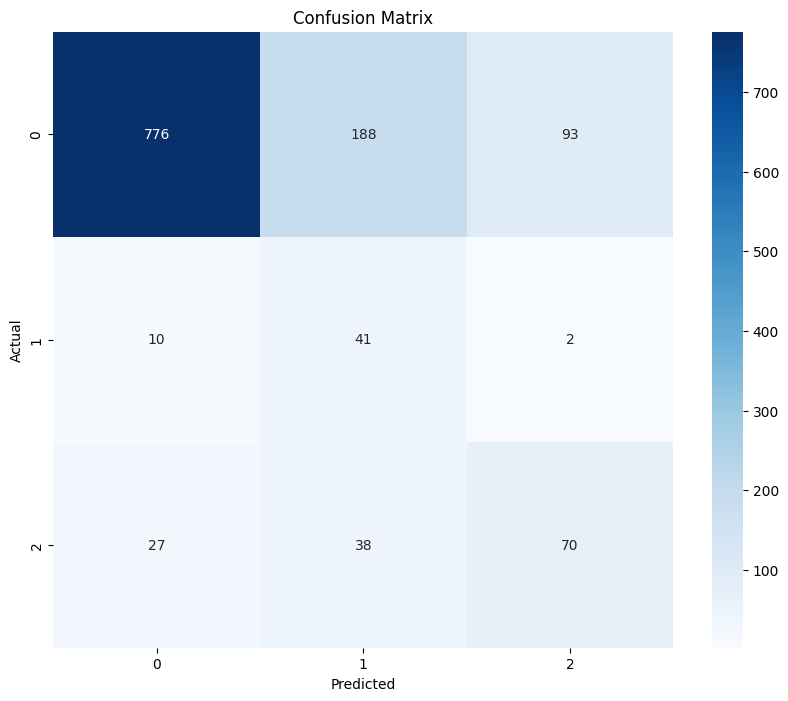

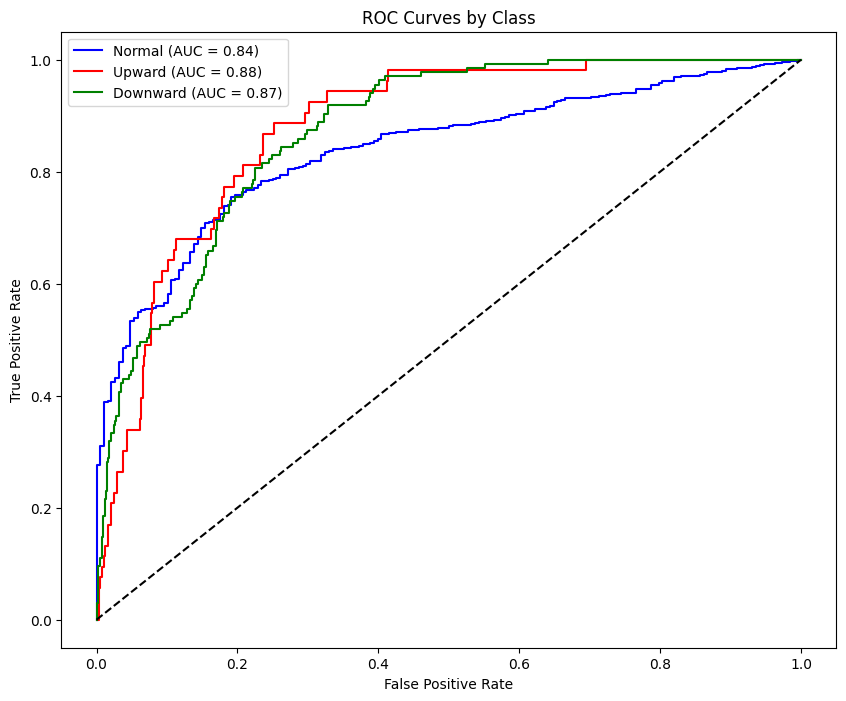


Model and scaler saved to disk.


In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns

def create_dataset():
    # Download data
    sp500 = yf.Ticker("^SPX")
    df = sp500.history(start="2000-01-01", end="2024-09-30", interval="1d")

    # Create initial features
    data = pd.DataFrame()
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Open'] = df['Open']
    data['Volume'] = df['Volume']

    # Calculate technical indicators
    # ATR periods
    data['ATR_14'] = df.ta.atr(length=14)
    data['ATR_20'] = df.ta.atr(length=20)

    # RSI
    data['RSI'] = df.ta.rsi(length=14)

    # Moving Averages
    data['SMA_20'] = df.ta.sma(length=20)
    data['SMA_50'] = df.ta.sma(length=50)
    data['SMA_200'] = df.ta.sma(length=200)

    # MACD
    macd = df.ta.macd()
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_Signal'] = macd['MACDs_12_26_9']

    # Other indicators
    data['ADX'] = df.ta.adx()['ADX_14']
    data['MFI'] = df.ta.mfi()
    data['Williams_R'] = df.ta.willr()

    # Calculate log returns for labels
    data['Log_Return'] = np.log(data['Close']/data['Close'].shift(1))
    data.fillna(0, inplace=True)

    # Calculate thresholds for labels
    mean_log = data['Log_Return'].mean()
    std_log = data['Log_Return'].std()

    # Adjust thresholds to be more selective for class 1
    upper_threshold = mean_log + 1.5 * std_log  # More selective for upward movements
    lower_threshold = mean_log - std_log

    # Create labels with focus on class 1
    def assign_label(x):
        if x > upper_threshold:
            return 1    # Significant upward movement (more selective)
        elif x < lower_threshold:
            return 2    # Significant downward movement
        else:
            return 0    # Normal movement

    data['Label'] = data['Log_Return'].apply(assign_label)

    # Select final features
    feature_columns = [col for col in data.columns if col not in ['Log_Return', 'Label']]
    X = data[feature_columns]
    y = data['Label']

    # Print class distribution
    print("\nClass Distribution:")
    dist = y.value_counts(normalize=True) * 100
    print(dist)

    return X, y

def train_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTETomek with higher sampling for class 1
    sampling_strategy = {1: int(len(y_train) * 0.4),  # Increase representation of class 1
                        2: int(len(y_train) * 0.3)}
    sampler = SMOTETomek(sampling_strategy=sampling_strategy, random_state=42)
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train_scaled, y_train)

    # Define class weights focusing on class 1
    class_weights = {0: 1,
                    1: 6,  # Heavily weight class 1
                    2: 2}

    # Train model
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,          # Reduced to prevent overfitting
        class_weight=class_weights,
        min_samples_split=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train_balanced, y_train_balanced)

    return rf, X_test_scaled, y_test, scaler

def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Print classification report
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    classes = [0, 1, 2]
    colors = ['blue', 'red', 'green']
    labels = ['Normal', 'Upward', 'Downward']

    for i, color, label in zip(classes, colors, labels):
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color,
                label=f'{label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Class')
    plt.legend()
    plt.show()

def main():
    print("Creating dataset...")
    X, y = create_dataset()

    print("\nTraining model...")
    model, X_test, y_test, scaler = train_model(X, y)

    print("\nEvaluating model...")
    evaluate_model(model, X_test, y_test)

    # Save only the essential files
    import joblib
    joblib.dump(model, 'rf_model.joblib')
    joblib.dump(scaler, 'scaler.joblib')

    print("\nModel and scaler saved to disk.")

if __name__ == "__main__":
    main()

# Appendix: How to Use the Resulting Model


This section demonstrates how to load and use the trained model for making predictions
on new data.

Two key models available:
1. General Accuracy Model ('best_model.joblib'): Optimized for overall accuracy
2. Label 1 Focus Model ('rf_model.joblib'): Optimized for capturing upward movements

Essential Components:
- Trained model: Contains the learned patterns
- Scaler: Ensures new data matches training data scale
- Selected features: The optimal feature subset identified during training

Important Notes:
- Always use the exact same features used in training
- Apply the scaler to new data before prediction
- Maintain the same feature order as during training

The example below shows the basic loading process. For actual trading:
1. Create the required technical indicators for new data
2. Select only the features found in 'best_features.txt'
3. Scale the features using the saved scaler
4. Use model.predict() for classifications
5. Consider model.predict_proba() for prediction confidence

In [30]:
# Load dependencies
import joblib

# Load the model and scaler
model = joblib.load('best_model.joblib')
scaler = joblib.load('scaler.joblib')

# Load selected features
with open('best_features.txt', 'r') as f:
   best_features = [line.strip() for line in f.readlines()]

# Make predictions on new data
# Make sure to:
# 1. Use only the selected features
# 2. Scale the features using the loaded scaler
# 3. Ensure the feature order matches the training data